In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

pd.set_option('display.precision', 3)

In [2]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_path = "/content/gdrive/MyDrive/Hydrogenase/MachineLearning/JNs/"
else:
    file_path = "./"

data = pd.read_csv(file_path+'Df_H2ase_CO.csv')
data.shape

# Split the data into features (X) and target variable (y)
X = data.drop(["Trajectory", "Frame", "Pathway-new","Binary"], axis=1)  # Features
y = data['Binary']  # Target variable
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=1)

# Split the validation & test subset into validation and test sets equally
# exclude the test set from consideration
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1)

# oversample the trainin set
oversampler = RandomOverSampler(random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

Mounted at /content/gdrive


In [3]:
data = pd.read_csv(file_path+'Mdg_H2ase_CO.csv')
data = data.drop(["Trajectory", "Frame", "Pathway-new"], axis=1)

X_NewCO = data.drop('Binary', axis=1)  # Features
y_NewCO = data['Binary']  # Target variable

In [4]:
data = pd.read_csv(file_path+'Df_H2ase_O2.csv')
data = data.drop(["Trajectory", "Frame", "Pathway-new"], axis=1)

X_O2 = data.drop('Binary', axis=1)  # Features
y_O2 = data['Binary']  # Target variable

In [5]:
data = pd.read_csv(file_path+'Df_H2ase_H2.csv')
data = data.drop(["Trajectory", "Frame", "Pathway-new"], axis=1)

X_H2 = data.drop('Binary', axis=1)  # Features
y_H2 = data['Binary']  # Target variable

In [6]:
# customized function to calculate the predictions and metrics
def calc_metrics(y, y_pred):
    acc = accuracy_score(y, y_pred)
    ba = balanced_accuracy_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cm = confusion_matrix(y, y_pred, labels=["Primary","Secondary"])
    return(acc, ba, mcc, cm)

# customized function to plot the confusion matrices
def plot_heatmap(cm, classes, title, ax=None, adjust_yticks=False):
    if not ax:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=ax,
                xticklabels=classes, yticklabels=classes, annot_kws={"fontsize":11, "fontweight":"bold"})
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Observed', fontsize=12)
    if adjust_yticks:
        ax.tick_params(axis='y', rotation=90)
    ax.set_title(title, fontsize=14)

In [7]:
# Train the model with the selected hyperparameters
rfc = RandomForestClassifier(n_estimators=500, oob_score=True, max_samples=0.7, ccp_alpha=0.001, max_depth=15, random_state=1)

rfc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(ccp_alpha=0.001, max_depth=15, max_samples=0.7,
                       n_estimators=500, oob_score=True, random_state=1)

In [8]:
# calculate and display the results
ds_names = ["Df-H2ase-CO-train", "Df-H2ase-CO-val", "Df-H2ase-CO-test", "Df-H2ase-H2-test", "Df-H2ase-O2-test", "Mdg-H2ase-CO-test"]
ds_names_formatted = ['Training Set', 'Validation Set', 'Df-H$_2$ase-CO Test Set','Df-H$_2$ase-H$_2$ Test Set', 'Df-H$_2$ase-O$_2$ Test Set','Mdg-H$_2$ase-CO Test Set']
ds_features = [X_train, X_val, X_test, X_H2, X_O2, X_NewCO]
ds_target = [y_train, y_val, y_test, y_H2, y_O2, y_NewCO]

results_dict = {}

for i in range(len(ds_names)):
    y_pred = rfc.predict(ds_features[i])
    acc, ba, mcc, cm = calc_metrics(ds_target[i], y_pred)
    results_dict[ds_names[i]] = [y_pred, acc, ba, mcc, cm]

results_df = pd.DataFrame.from_dict(results_dict, orient="index",
                                    columns=["predictions", "accuracy", "BA", "MCC", "CM"])

display(results_df.loc[:,["accuracy", "BA", "MCC"]])

,accuracy,BA,MCC
Df-H2ase-CO-train,0.998,0.999,0.994
Df-H2ase-CO-val,0.927,0.903,0.795
Df-H2ase-CO-test,0.879,0.862,0.660
Df-H2ase-H2-test,0.851,0.849,0.714
Df-H2ase-O2-test,0.840,0.781,0.466
Mdg-H2ase-CO-test,0.947,0.819,0.638


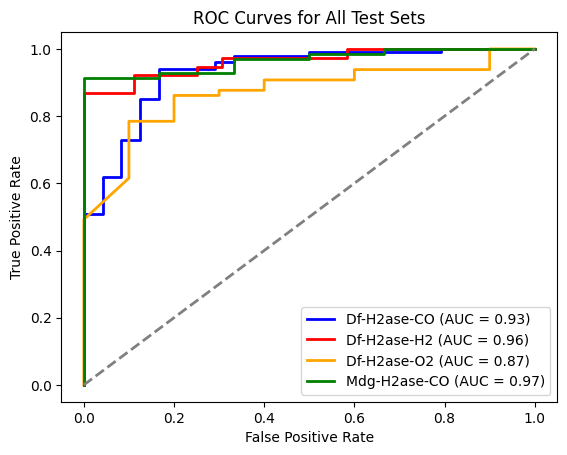

In [9]:
roc_fig, ax = plt.subplots(nrows=1, ncols=1)
colors = [None, None, 'blue', 'red', 'orange', 'green']

for i in range(2,6):
    RocCurveDisplay.from_estimator(rfc, ds_features[i], ds_target[i], pos_label="Primary", ax=ax,
                                   name=ds_names[i][:-5], color=colors[i], lw=2)

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Adjust limits to add padding around the edges
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Test Sets')
plt.legend(loc="lower right")

#plt.savefig('ROC-test-All.jpg', dpi=300, format='jpg')
plt.show()

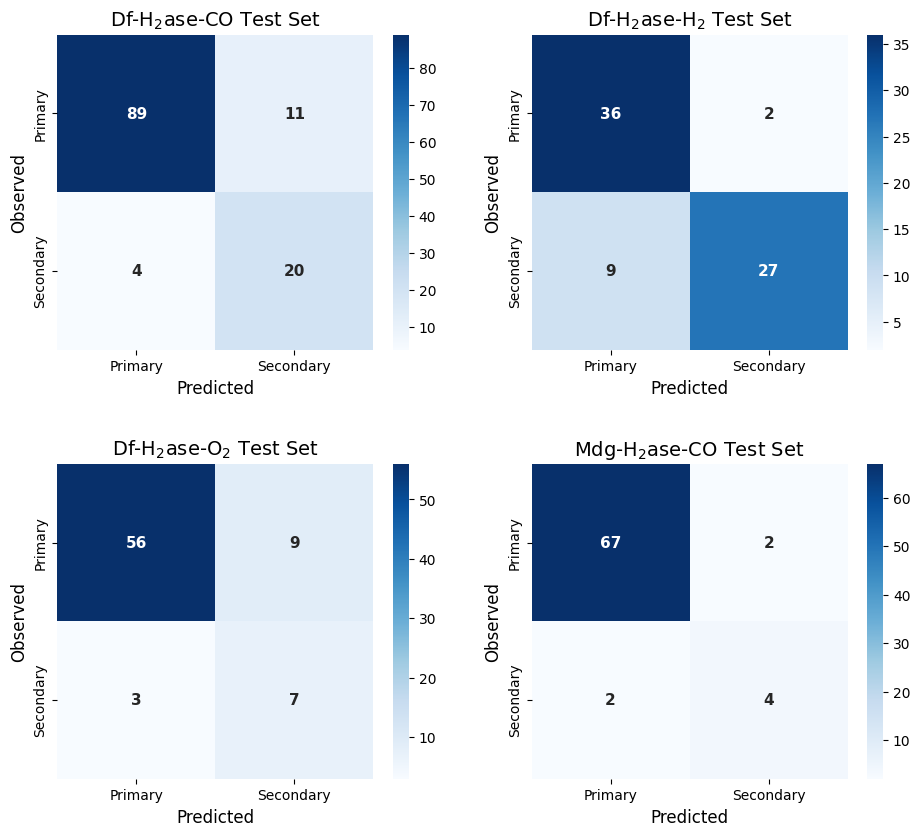

In [10]:
# make a figure space for 4 subplots (skip training set)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))
k = 0
for i, j in np.ndindex(axes.shape):
    # fetch the subplot by its coordinates in the figure space
    ax = axes[i,j]
    plot_heatmap(results_df.iloc[k+2,-1], ['Primary','Secondary'], ds_names_formatted[k+2],
                 ax, adjust_yticks=True)
    k += 1
fig.tight_layout(pad=3)
# plt.savefig('CM-Binary.jpeg', dpi=300, bbox_inches='tight')
plt.show()

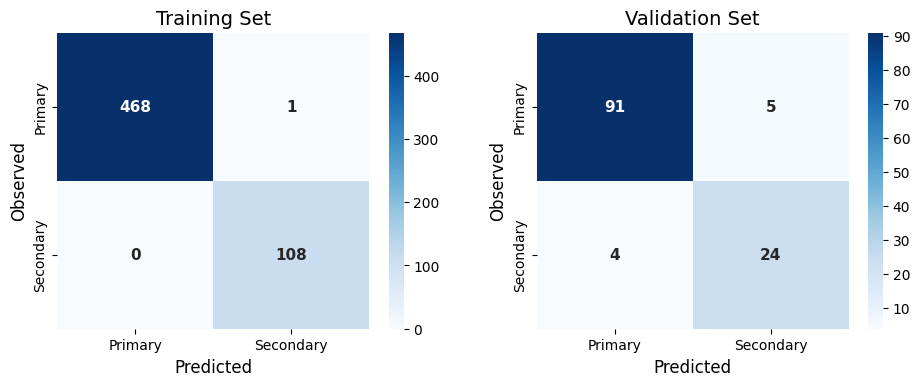

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))

for i in range(2):
    # fetch the subplot
    ax = axes[i]
    plot_heatmap(results_df.iloc[i,-1], ['Primary','Secondary'], ds_names_formatted[i],
                 ax, adjust_yticks=True)
plt.tight_layout(pad=3)
plt.show()

In [12]:
# Instantiate the DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=1)

# Fit the model on the resampled training data
dummy_clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_dummy = dummy_clf.predict(X_test)

# Assess accuracy on the test set
balanced_accuracy_test_dummy = balanced_accuracy_score(y_test, y_pred_dummy)
mcc_test_dummy = matthews_corrcoef(y_test, y_pred_dummy)

print(f'Baseline (Dummy Classifier) Balanced Accuracy on the test set: {balanced_accuracy_test_dummy:.2f}')
print(f'Baseline (Dummy Classifier) Matthews Correlation Coefficient on the test set: {mcc_test_dummy:.2f}')

# Predict on the training set
y_pred_train_dummy = dummy_clf.predict(X_train)

# Assess accuracy on the training set
balanced_accuracy_train_dummy = balanced_accuracy_score(y_train, y_pred_train_dummy)
mcc_train_dummy = matthews_corrcoef(y_train, y_pred_train_dummy)

print(f'Baseline (Dummy Classifier) Balanced Accuracy on the training set: {balanced_accuracy_train_dummy:.2f}')
print(f'Baseline (Dummy Classifier) Matthews Correlation Coefficient on the training set: {mcc_train_dummy:.2f}')


Baseline (Dummy Classifier) Balanced Accuracy on the test set: 0.50
Baseline (Dummy Classifier) Matthews Correlation Coefficient on the test set: 0.00
Baseline (Dummy Classifier) Balanced Accuracy on the training set: 0.50
Baseline (Dummy Classifier) Matthews Correlation Coefficient on the training set: 0.00


In [13]:
y_train_scrambled = shuffle(y_train, random_state=1)
X_train_scram_resampled, y_train_scram_resampled = oversampler.fit_resample(X_train, y_train_scrambled)

rfc_scram = RandomForestClassifier(n_estimators=500, oob_score=True, max_samples=0.7, ccp_alpha=0.001, max_depth=15, random_state=1)
rfc_scram.fit(X_train_scram_resampled, y_train_scram_resampled)

# Predict on the training set with scrambled labels
y_pred_train_scrambled = rfc_scram.predict(X_train)
y_scram_pred_test = rfc_scram.predict(X_test)

# Assess accuracy on the training set with scrambled labels
balanced_accuracy_train_scrambled = balanced_accuracy_score(y_train_scrambled, y_pred_train_scrambled)
mcc_train_scrambled = matthews_corrcoef(y_train_scrambled, y_pred_train_scrambled)
balanced_accuracy_test_scrambled = balanced_accuracy_score(y_test, y_scram_pred_test)
mcc_test_scrambled = matthews_corrcoef(y_test, y_scram_pred_test)

print(f'Scrambled Balanced Accuracy on the training set: {balanced_accuracy_train_scrambled:.2f}')
print(f'Scrambled Matthews Correlation Coefficient on the training set: {mcc_train_scrambled:.2f}')
print(f'Scrambled Balanced Accuracy on the test set: {balanced_accuracy_test_scrambled:.2f}')
print(f'Scrambled Matthews Correlation Coefficient on the test set: {mcc_test_scrambled:.2f}')

Scrambled Balanced Accuracy on the training set: 0.99
Scrambled Matthews Correlation Coefficient on the training set: 0.99
Scrambled Balanced Accuracy on the test set: 0.46
Scrambled Matthews Correlation Coefficient on the test set: -0.10
